TRANSFER LEARNING:

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1.Take layers from a previously trained model.
2.Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3.Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4.Train the new layers on your dataset.

FINE TUNING:

A last, optional step, is fine-tuning, which consists of unfreezing the entire 
model you obtained above (or part of it), and re-training it on the new data with
a very low learning rate. This can potentially achieve meaningful improvements,
by incrementally adapting the pretrained features to the new data.

In [ ]:
pip install tensorflow.keras.applications.inception_v3

ERROR: Could not find a version that satisfies the requirement tensorflow.keras.applications.inception_v3 (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.applications.inception_v3


In [ ]:
# https://keras.io/api/applications/inceptionv3/
# Documentation for Inception_V3 (keras)

import os


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model


!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-09-03 17:21:13--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.128, 173.194.74.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   162MB/s    in 0.5s    

2021-09-03 17:21:13 (162 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)
# INCLUDE_TOP :  Boolean, whether to include the fully-connected layer at the top,
# as the last layer of the network. Default to True.
# INPUT_SHAPE : Optional shape tuple, only to be specified if include_top is False 
# (otherwise the input shape has to be (299, 299, 3) (with channels_last data format)
# or (3, 299, 299) (with channels_first data format). It should have exactly 3 inputs 
# channels, and width and height should be no smaller than 75. E.g. 
# (150, 150, 3) would be one valid value. input_shape will be ignored if
# the input_tensor is provided.
# WEIGHTS : One of None (random initialization), imagenet (pre-training on ImageNet),
# or the path to the weights file to be loaded. Default to imagenet.

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer_trainable = False # The state of layers or say the state remains same 

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


Most of these models are a series of convolutional layers followed by one or a few dense (or fully connected) layers.

Include_top lets you select if you want the final dense layers or not.

the convolutional layers work as feature extractors. They identify a series of patterns in the image, and each layer can identify more elaborate patterns by seeing patterns of patterns.

the dense layers are capable of interpreting the found patterns in order to classify: this image contains cats, dogs, cars, etc.

About the weights:

the weights in a convolutional layer are fixed-size. They are the size of the kernel x filters. Example: a 3x3 kernel of 10 filters. A convolutional layer doesn't care about the size of the input image. It just does the convolutions and present a resulting image based on the size of the input image. (Search for some illustrated tutorials about convolutions if this is unclear)

now the weights in a dense layer are totally dependent on the input size. It's one weight per element of the input. So this demands that your input be always the same size, or else you won't have proper learned weights.

Because of this, removing the final dense layers allows you to define the input size (see in documentation). (And the output size will increase/decrease accordingly).

But you lose the interpretation/classification layers. (You can add your own, depending on your task)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
# Flatten the output layer to 1 dimension 
x = layers.Dense(1024, activation = 'relu')(x)
# Add a fully connected layer with 1024 hidden units and RELU activation
x = layers.Dropout(0.2)(x)
# Add a Dropout rate of 0.2
x = layers.Dense(1, activation = 'sigmoid')(x)
# Add a final sigoid layer for cllasification

model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
!gdown --id 1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Adding data augmentation params to ImageDataGenarator
train_datagen = ImageDataGenerator( rescale = 1./255,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True
                                  )

# NOTE!!!! validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size =  20,
    class_mode = 'binary'
)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    batch_size = 20,
    target_size = (150,150),
    class_mode = 'binary'
)


Downloading...
From: https://drive.google.com/uc?id=1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9
To: /content/cats_and_dogs_filtered.zip
68.6MB [00:00, 146MB/s]
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    validation_steps = 50,
    epochs = 20,
    verbose = 2
)

Epoch 1/20
100/100 - 27s - loss: 0.0678 - accuracy: 0.9770 - val_loss: 0.4547 - val_accuracy: 0.9600
Epoch 2/20
100/100 - 27s - loss: 0.0542 - accuracy: 0.9795 - val_loss: 1.5225 - val_accuracy: 0.9460
Epoch 3/20
100/100 - 27s - loss: 0.0837 - accuracy: 0.9790 - val_loss: 0.6812 - val_accuracy: 0.9510
Epoch 4/20
100/100 - 28s - loss: 0.0681 - accuracy: 0.9820 - val_loss: 46.9821 - val_accuracy: 0.8620
Epoch 5/20
100/100 - 28s - loss: 0.1034 - accuracy: 0.9790 - val_loss: 2.5634 - val_accuracy: 0.9510
Epoch 6/20
100/100 - 27s - loss: 0.0896 - accuracy: 0.9850 - val_loss: 2.2903 - val_accuracy: 0.9490
Epoch 7/20
100/100 - 27s - loss: 0.0422 - accuracy: 0.9845 - val_loss: 0.5377 - val_accuracy: 0.9630
Epoch 8/20
100/100 - 28s - loss: 0.0340 - accuracy: 0.9895 - val_loss: 0.4160 - val_accuracy: 0.9620
Epoch 9/20
100/100 - 28s - loss: 0.0364 - accuracy: 0.9900 - val_loss: 0.3957 - val_accuracy: 0.9590
Epoch 10/20
100/100 - 27s - loss: 0.0526 - accuracy: 0.9865 - val_loss: 0.8560 - val_accur

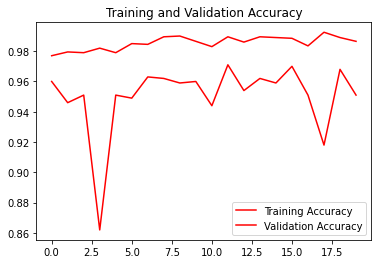

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'r', label = "Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend(loc = 0)
plt.figure()

plt.show()